# BCI Project: Pre-Processing Steps

## By BrainRot: Selma Ancel & Lotte Michels

This notebook closely follows the OpenMIIR EEG data pre-processing steps described by Stober (2017). Please refer to the original paper or our project submission for a textual description of the pre-processing steps. The notebook and comments in the code will also provide an outline of the steps that are performed. Code was inspired by the original legacy code by Stober (2017) and recreated using the MNE Python package. 

### References:
- Stober, S. (2017). Toward Studying Music Cognition with Information Retrieval Techniques: Lessons Learned from the OpenMIIR Initiative. Frontiers in Psychology, 8. https://doi.org/10.3389/fpsyg.2017.01255. Related code is published here: https://github.com/sstober/openmiir.
- Gramfort, A., Luessi, M., Larson, E., Engemann, D. A., Strohmeier, D., Brodbeck, C., Goj, R., Jas, M., Brooks, T., Parkkonen, L., & Hämäläinen, M. (2013). MEG and EEG data analysis with MNE-Python. Frontiers in Neuroscience, 7, 267. https://doi.org/10.3389/fnins.2013.00267

In [1]:
import mne
from mne.preprocessing import ICA
from mne import pick_types
import librosa
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tkinter as tk
import collections
%matplotlib inline

## Load and inspect data

In [2]:
subj = '01' # Fill in the subject number for the file you want to process
raw = mne.io.read_raw_fif("/kaggle/input/openmiir/P{}-raw.fif".format(subj), preload=True) # Load data for participant of interest

Opening raw data file /kaggle/input/openmiir/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...


In [3]:
print(raw.info)
print(raw.info['ch_names'])

<Info | 11 non-empty values
 bads: 3 items (P8, P10, T8)
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 4 EOG, 1 Stimulus
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2015-01-28 17:39:57 UTC
 meas_id: 4 items (dict)
 nchan: 69
 projs: Average EEG reference: off
 sfreq: 512.0 Hz
>
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'STI 014']


In [4]:
# Set reference
MASTOID_CHANNELS = [u'EXG5', u'EXG6']
if all(channels in raw.info['ch_names'] for channels in MASTOID_CHANNELS): # Check if the data contains the EXG5 and EXG6 mastoid channels
    print('Rereferencing to mastoids')
    raw.set_eeg_reference(ref_channels=MASTOID_CHANNELS)
else:
    print('Rereferencing to average')
    raw.set_eeg_reference()

Rereferencing to average
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.


In [ ]:
raw.plot()
plt.show()

Using matplotlib as 2D backend.


## Reject and interpolate bad channels

In [ ]:
print(raw.info["bads"]) # These bad channels were manually selected by Stober (2017)

['P8', 'P10', 'T8']


In [7]:
#montage = Biosemi64Layout().as_montage()
if 'EXG5' in raw.info['ch_names'] and 'EXG6' in raw.info['ch_names']:
    raw.set_channel_types({'EXG5': 'misc', 'EXG6': 'misc'})
montage = mne.channels.make_standard_montage('biosemi64') # Biosemi64 montage is used by Stober (2017) in https://github.com/sstober/deepthought/blob/master/deepthought/datasets/openmiir/preprocessing/pipeline.py 
raw.set_montage(montage) # Montage needs to be set before interpolation can take place # on_missing='warn'

<Raw | P01-raw.fif, 69 x 2478166 (4840.2 s), ~1.27 GiB, data loaded>

In [8]:
raw.interpolate_bads() # Interpolate rejected channels

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors


<Raw | P01-raw.fif, 69 x 2478166 (4840.2 s), ~1.27 GiB, data loaded>

In [9]:
print(raw.info["bads"]) # Check: This list should be cleared after interpolation

[]


## Check and Merge trials (align with audio onsets)

540 events found on stim channel STI 014
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]


/tmp/ipykernel_31/3693777613.py:6: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(trial_events)


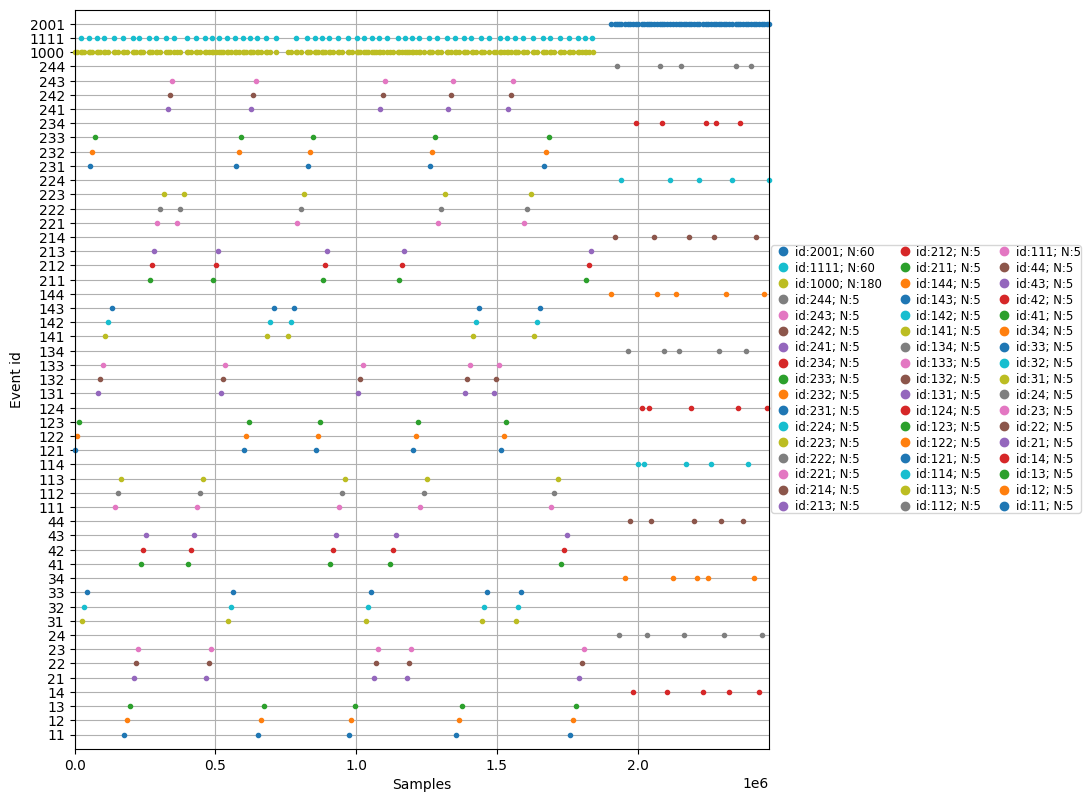

1st event at  1.0
last event at  4820.166015625


In [10]:
# This simulates Stober's 'check_trial_events' function

trial_events = mne.find_events(raw, stim_channel='STI 014')
#print(trial_events[:10])

mne.viz.plot_events(trial_events)

print( '1st event at ', raw.times[trial_events[0,0]])
print( 'last event at ', raw.times[trial_events[-1,0]])

trial_event_times = raw.times[trial_events[:,0]]



In [11]:
# filtered_events = trial_events[trial_events[:, 2] != 1000] # audio onset
# filtered_events = filtered_events[filtered_events[:, 2] != 1111] # noise onset
# filtered_events = trial_events[trial_events[:, 2] != 2001] # 'correct' feedback in condition 4
# # ID = 2000 represents 'incorrect' feedback in condition 4 (not relevant for participant 1)

# print(filtered_events[:10]) 

# mne.viz.plot_events(filtered_events)

# print( '1st event at ', raw.times[filtered_events[0,0]])
# print( 'last event at ', raw.times[filtered_events[-1,0]])

# # Get event times (in seconds) from raw.times using event sample indices
# event_times = raw.times[filtered_events[:, 0]]

# # Calculate the time differences (duration) between consecutive events
# event_durations = np.diff(event_times)

# # Add a 20 duration for the last event (close to the expected duration of the trial for Hedwig's themse (16 secs))
# event_durations = np.append(event_durations, 20)

# # Now, print durations for each event in trial_events
# event_ids = filtered_events[:, 2]  # Event IDs
# unique_event_ids = np.unique(event_ids)

# for event_id in unique_event_ids:
#     # Find events with this event_id
#     event_indices = event_ids == event_id

#     # Get the corresponding durations for these events
#     event_duration = event_durations[event_indices]

#     # Calculate the average duration of the events with this ID
#     avg_duration = np.mean(event_duration)
#     print(f"Event ID {event_id}: Average duration = {avg_duration:.3f} seconds")


/tmp/ipykernel_31/2677979460.py:43: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(merged_events, raw.info['sfreq'], raw.first_samp, axes=axes)


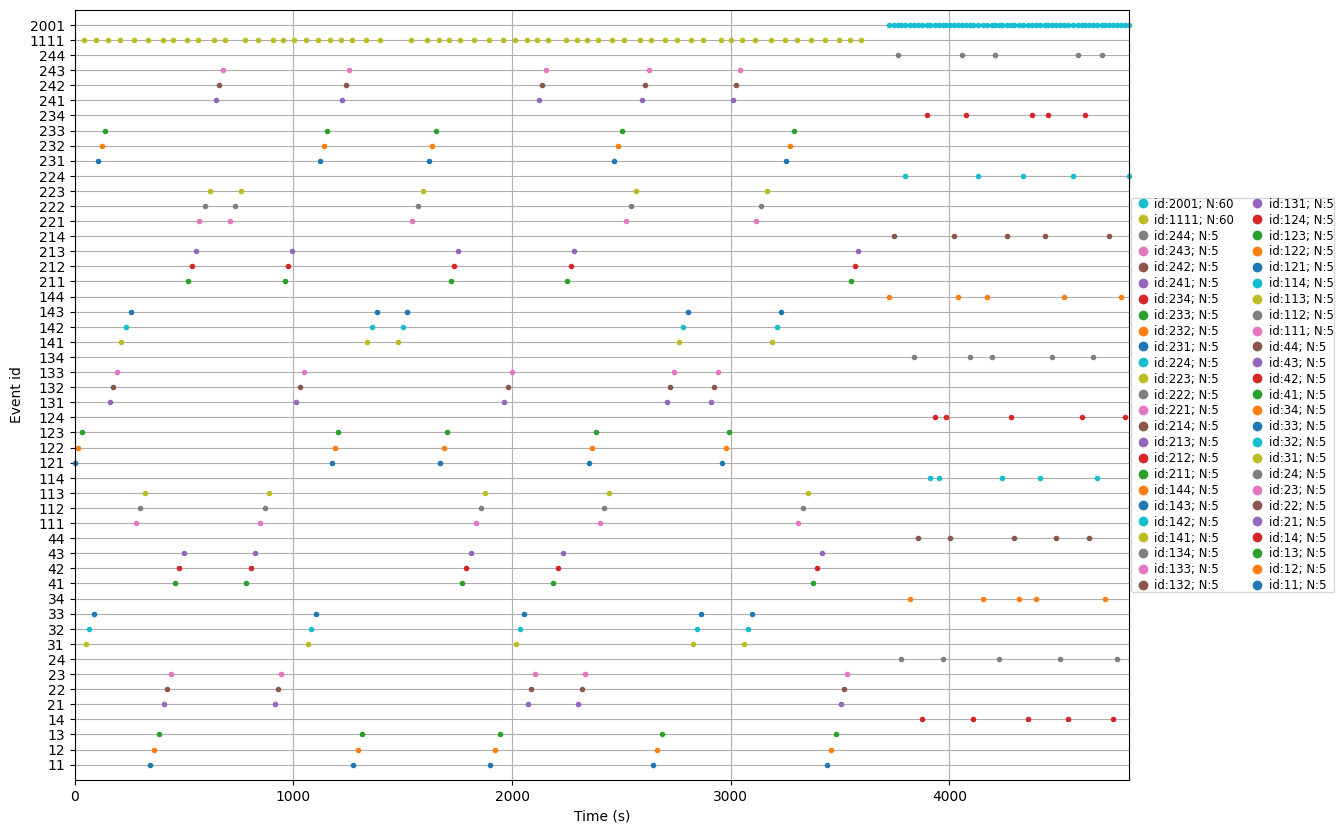

In [12]:
def merge_trial_and_audio_onsets(raw, trial_events, use_audio_onsets=True, inplace=False, verbose=None): # from https://github.com/sstober/deepthought/blob/master/deepthought/datasets/openmiir/preprocessing/events.py
    events = trial_events

    merged = list()
    last_trial_event = None
    for i, event in enumerate(events):
        etype = event[2]
        if etype < 1000 or etype == 1111: # trial or noise onset
            if use_audio_onsets and events[i+1][2] == 1000: # followed by audio onset
                onset = events[i+1][0]
                merged.append([onset, 0, etype])
                if verbose:
                    print('merged {} + {} = {}'.format(event, events[i+1], merged[-1]))
            else:
                # either we are not interested in audio onsets or there is none
                merged.append(event)
                if verbose:
                    print('kept {}'.format(merged[-1]))
        # audio onsets (etype == 1000) are not copied
        if etype > 1111: # other events (keystrokes)
            merged.append(event)
            if verbose:
                print('kept other {}'.format(merged[-1]))

    merged = np.asarray(merged, dtype=int)

    if inplace: # Not the case!
        stim_id = raw.ch_names.index('STI 014')
        raw._data[stim_id,:].fill(0)     # delete data in stim channel
        raw.add_events(merged)

    return merged




# This simulates Stober's 'check_trial_audio_onset_merge' function 

merged_events = merge_trial_and_audio_onsets(raw, trial_events)

plt.figure(figsize=(17,10))
axes = plt.gca()
mne.viz.plot_events(merged_events, raw.info['sfreq'], raw.first_samp, axes=axes)
plt.show()


In [13]:
# This simulates Stober's 'merge_trial_and_audio_onsets' function

merge_trial_and_audio_onsets(raw, trial_events, use_audio_onsets=True, inplace=True)

# recompute trial_events and times
trial_events = mne.find_events(raw, stim_channel='STI 014', shortest_event=0)
trial_event_times = raw.times[trial_events[:,0]]



360 events found on stim channel STI 014
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1111 2001]


## Bandpass filtering

Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


<Figure size 640x480 with 0 Axes>

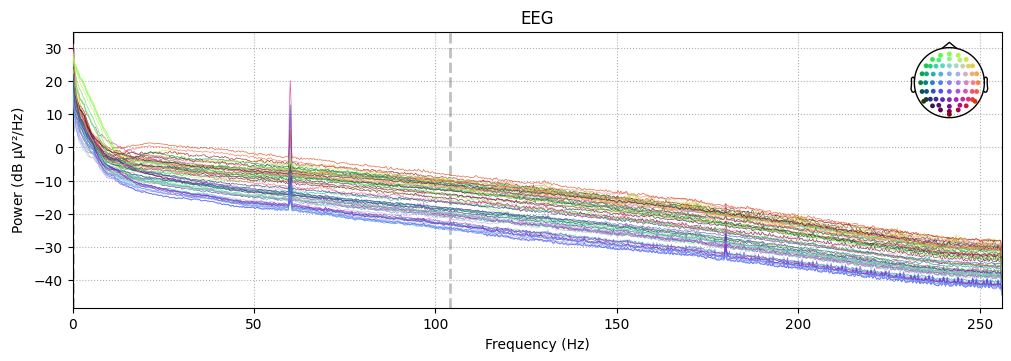

In [14]:
plt.figure()
raw.compute_psd().plot() # Line noise is visible at multiples of 60Hz
plt.show()

In [15]:
raw.filter(0.5, 30, l_trans_bandwidth=0.1, h_trans_bandwidth=0.5, method='fft',n_jobs=4, verbose=True) # Same as in Stober's (2017) pipeline

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 30.25 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:    9.2s finished


<Raw | P01-raw.fif, 69 x 2478166 (4840.2 s), ~1.27 GiB, data loaded>

Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


<Figure size 640x480 with 0 Axes>

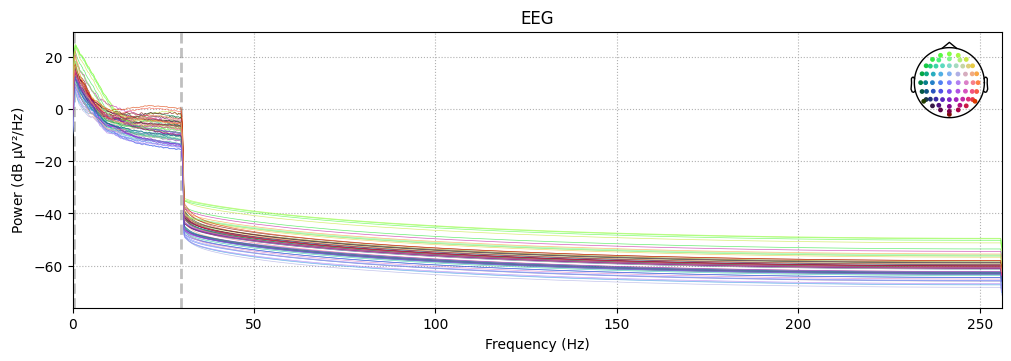

In [16]:
plt.figure()
raw.compute_psd().plot() # To check the effect of bandpass filtering: line noise is removed
plt.show()

Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


<Figure size 640x480 with 0 Axes>

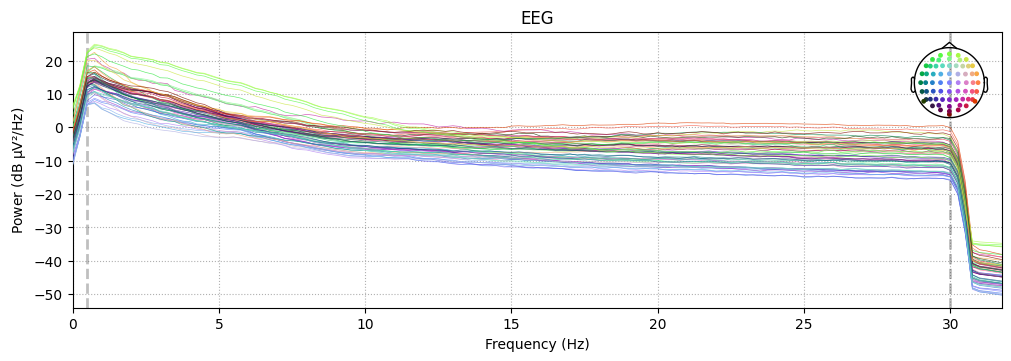

In [17]:
plt.figure()
raw.compute_psd(fmax=31.9).plot() # Zoom in
plt.show()

## EOG Epoching

Using EOG channels: EXG1, EXG2, EXG3, EXG4
EOG channel index for this subject is: [64 65 66 67]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EXG2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 1579 significant peaks
Number of EOG events detected: 1579


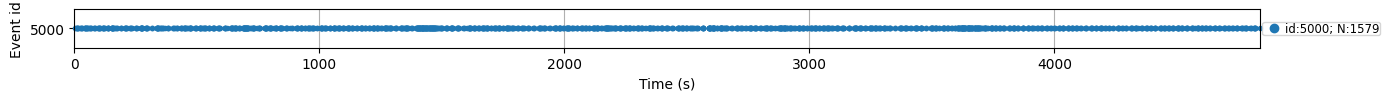

In [18]:
# This simulates Stober's 'find_eog_events' function

# check for EOG artifacts:
eog_event_id = 5000
eog_events = mne.preprocessing.find_eog_events(raw, eog_event_id)

plt.figure(figsize=(17,0.5))
axes = plt.gca()
mne.viz.plot_events(eog_events, raw.info['sfreq'], raw.first_samp, axes=axes)

# create epochs around EOG events
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True, stim=True, exclude=[]) 
tmin = -.5
tmax = .5
eog_epochs = mne.Epochs(raw, events=eog_events, event_id=eog_event_id, tmin=tmin, tmax=tmax, proj=False, picks=picks, preload=True, verbose=False)


## Downsampling

In [19]:
# This simulates Stober's 'downsample' function

sfreq=64
print('down-sampling raw and events stim channel ...')
stim_picks = mne.pick_types(raw.info, meg=False, stim=True)
raw.resample(sfreq, npad="auto", stim_picks=stim_picks, n_jobs=1, verbose=True)
# resample epochs
print('down-sampling epochs ...')
eog_epochs.resample(sfreq)
print(f'New raw data shape: {raw._data.shape}')
print(f'New sampling frequency: {raw.info["sfreq"]} Hz')


down-sampling raw and events stim channel ...
360 events found on stim channel STI 014
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1111 2001]
360 events found on stim channel STI 014
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1111 2001]
down-sampling epochs ...
New raw data shape: (69, 309771)
New sampling frequency: 64.0 Hz


Effective window size : 32.000 (s)
Plotting power spectral density (dB=True).


<Figure size 640x480 with 0 Axes>

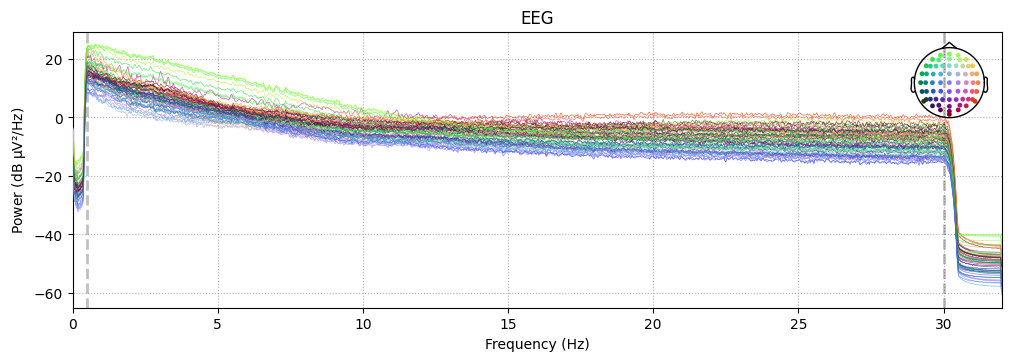

In [20]:
# PSD after down-sampling:
plt.figure()
raw.compute_psd(fmax=32).plot() # Zoom in
plt.show()

360 events found on stim channel STI 014
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1111 2001]


/tmp/ipykernel_31/3616194968.py:6: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(resampled_trial_events, raw.info['sfreq'], raw.first_samp, axes=axes) #, color=color, event_id=event_id)


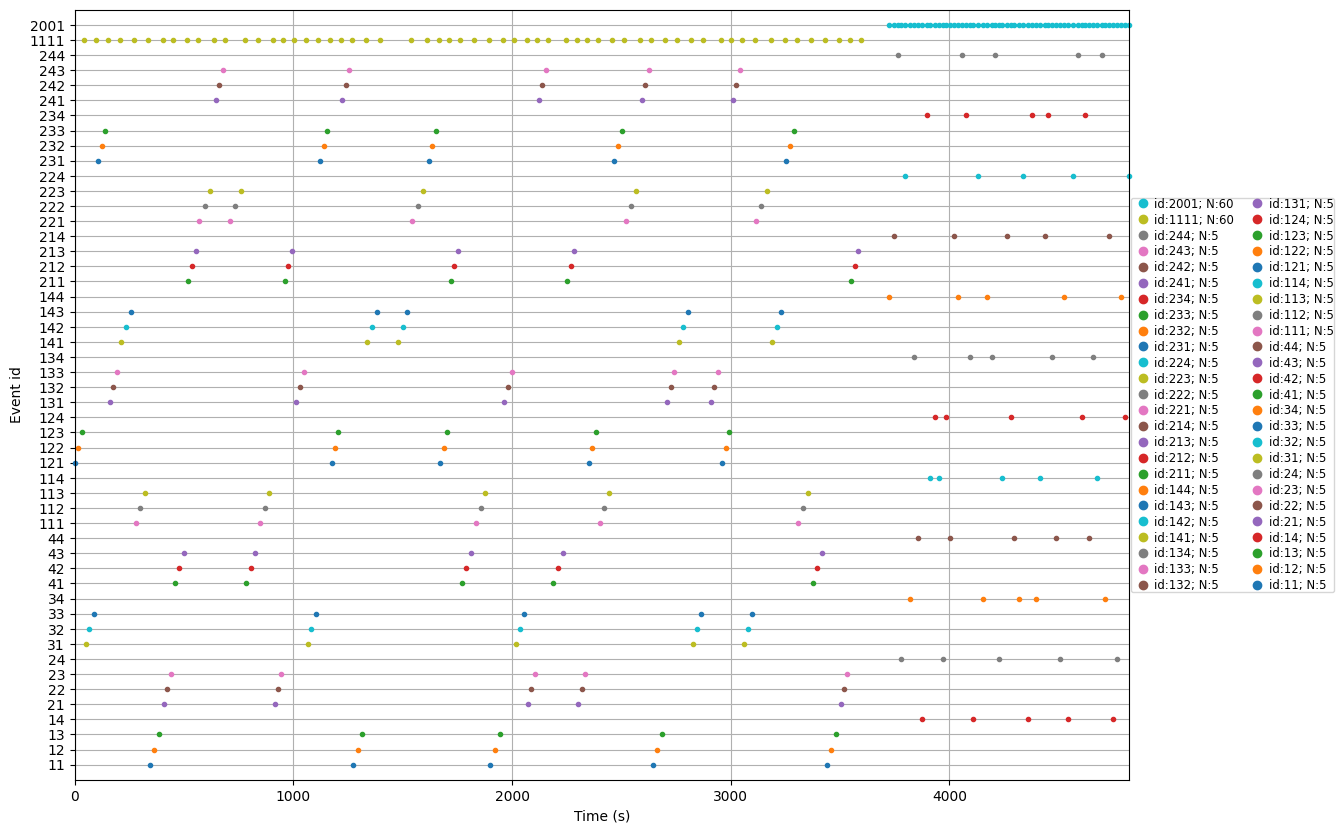

event onset jitter (min, mean, max): -0.01171875 -0.003917100694444444 0.00390625


In [21]:
# check events after after resampling -> should get the same result as above
resampled_trial_events = mne.find_events(raw, stim_channel='STI 014', shortest_event=0)

plt.figure(figsize=(17,10))
axes = plt.gca()
mne.viz.plot_events(resampled_trial_events, raw.info['sfreq'], raw.first_samp, axes=axes) #, color=color, event_id=event_id)
plt.show()

resampled_trial_event_times = raw.times[resampled_trial_events[:,0]]

diff = resampled_trial_event_times - trial_event_times
print('event onset jitter (min, mean, max):', diff.min(), diff.mean(), diff.max())
diff = np.asarray(diff*1000, dtype=int)


/tmp/ipykernel_31/1218823570.py:7: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(final_events)


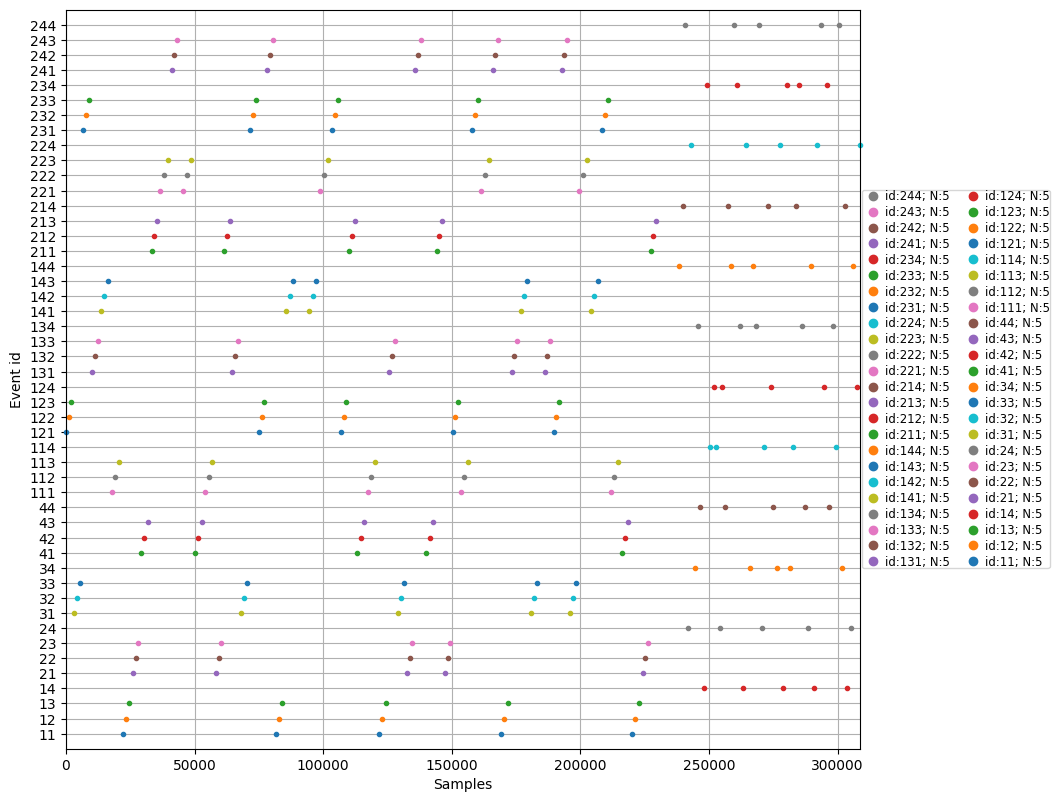

In [22]:
# Filter out 1111 and 2000/2001: not relevant for our project
final_events = resampled_trial_events[resampled_trial_events[:, 2] != 1111] # noise onset
final_events = final_events[final_events[:, 2] != 2001] # 'correct' feedback in condition 4
final_events = final_events[final_events[:, 2] != 2000] # 'incorrect' feedback in condition 4 (not relevant for participant 1)
final_event_times = raw.times[final_events[:,0]]

mne.viz.plot_events(final_events)
plt.show()

## Artefact removal: ICA

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by explained variance: 17 components
Computing Infomax ICA
Fitting ICA took 42.0s.


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


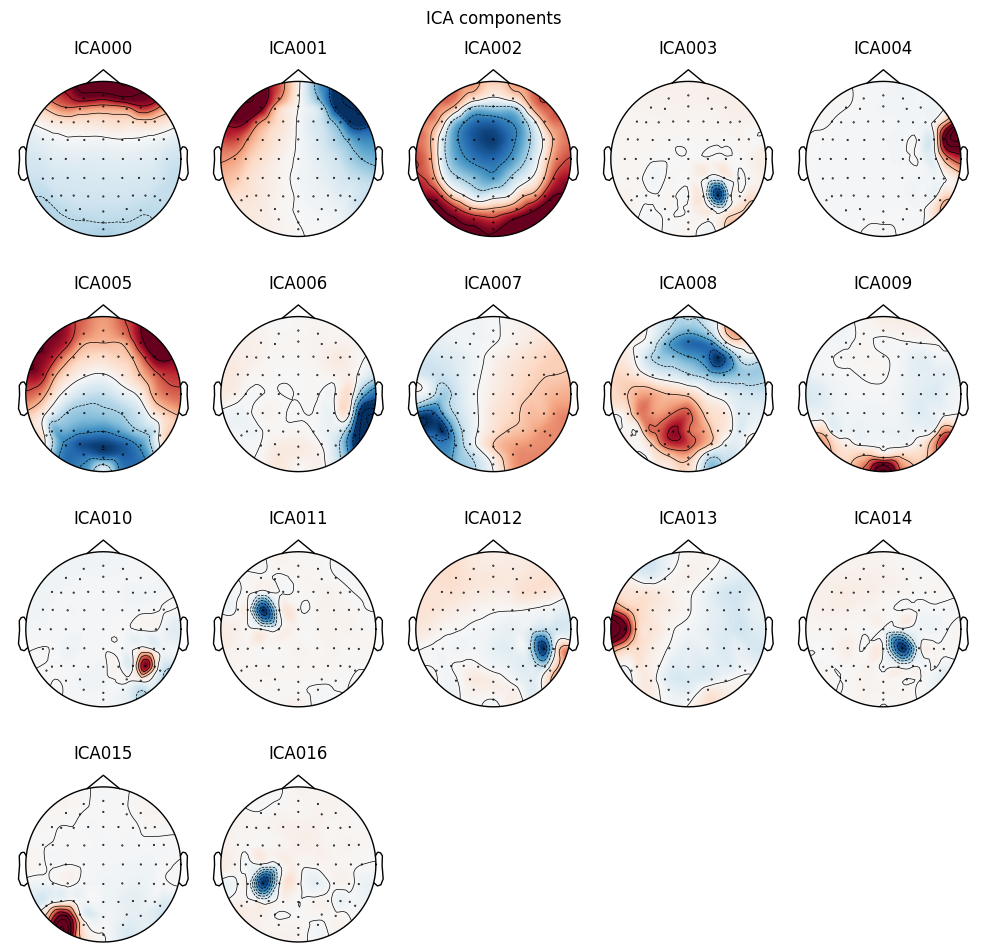

Creating RawArray with float64 data, n_channels=21, n_times=309771
    Range : 0 ... 309770 =      0.000 ...  4840.156 secs
Ready.


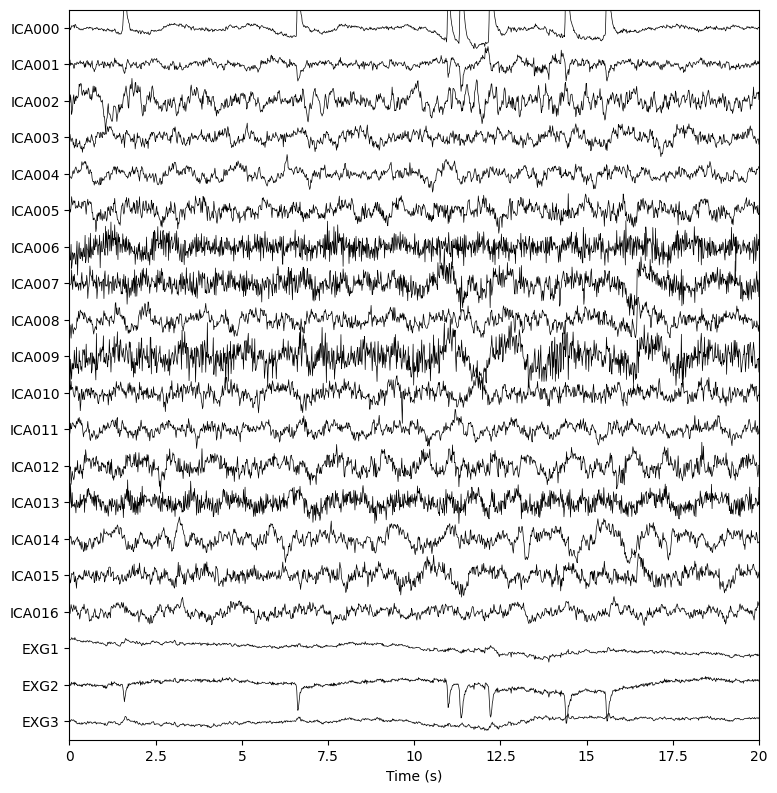

In [23]:
random_state = np.random.RandomState(42)
ica = ICA(n_components=0.95, method='infomax', random_state=random_state, verbose=None) # ICA fitting is not deterministic so we specify a random seed (42) to get the same results each time we run the code
ica.fit(raw)
ica.plot_components()
ica.plot_sources(raw, show_scrollbars=False)
plt.show()


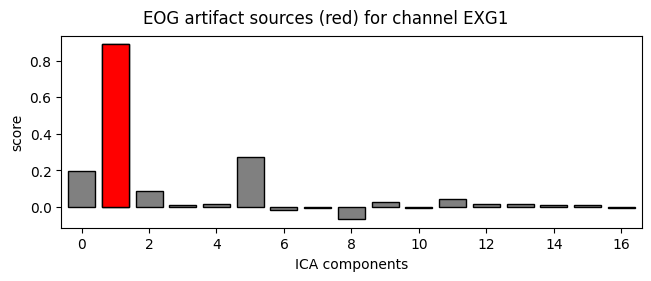

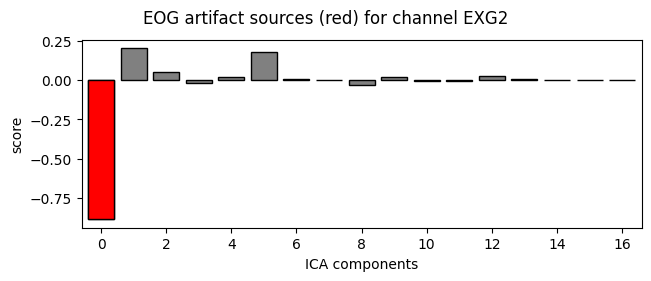

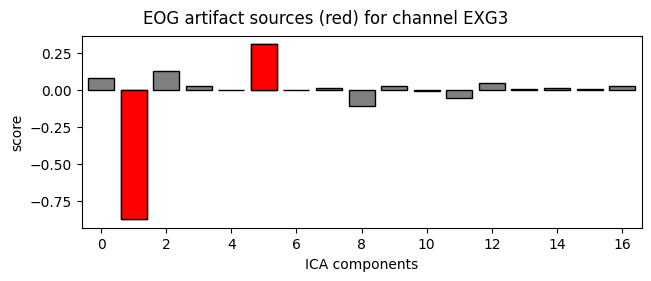

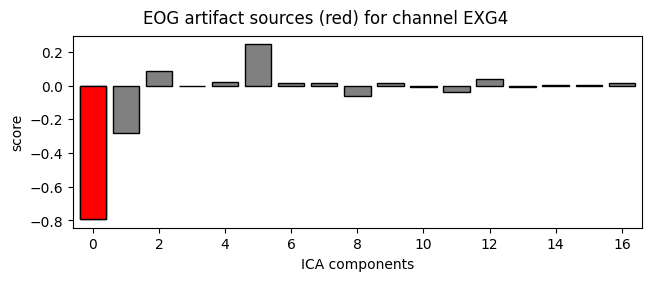

suggested EOG artifact channels:  [0, 1, 5]
EOG artifact component scores:  [0.88721413 0.88821054 0.30909678]


In [24]:
# Simulation of Stober's 'find_eog_artifact_sources' function

eog_picks = mne.pick_types(raw.info, meg=False, eeg=False, eog=True, stim=False)
eog_inds_set = set()
multi_scores = list()
for ch in eog_picks:
    ch_name = raw.ch_names[ch]
    eog_inds, scores = ica.find_bads_eog(raw, str(ch_name), verbose=False)
    ica.plot_scores(scores, exclude=eog_inds, title='EOG artifact sources (red) for channel {}'.format(ch_name))
    multi_scores.append(scores)
    eog_inds_set.update(eog_inds)
multi_scores = np.vstack(multi_scores)
eog_inds = list(eog_inds_set)
eog_scores = np.max(np.abs(multi_scores), axis=0).squeeze()

print('suggested EOG artifact channels: ', eog_inds)
print('EOG artifact component scores: ', eog_scores[eog_inds])



Effective window size : 32.000 (s)
merging [[0, 1, 5], []]
suggested channels to reject (selection="auto"):  [0, 1, 5]


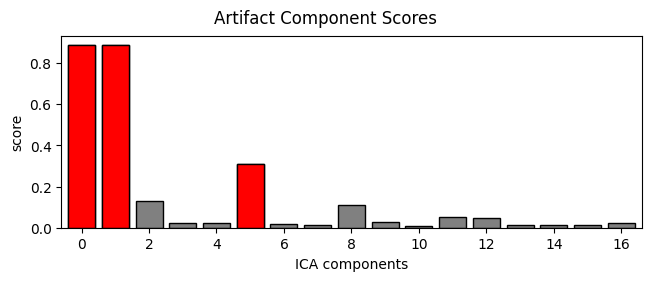

current selection: [0, 1, 5]


In [25]:
# Simulation of Stober's 'auto_detect_artifact_components' function

exclude_old = ica.exclude  # store old setting
ica.exclude = []
ica.find_bads_muscle(raw, h_freq=31.9) # original 'ica.detect_artifacts(raw)' is deprecated
auto_exclude = ica.exclude
ica.exclude = exclude_old  # restore old setting

sets = list()
sets.append(eog_inds)
sets.append(auto_exclude)

if len(sets) == 1:
    merged = sets[0]
else:
    print('merging', sets)
    merged = set()
    for s in sets:
        for e in s:
            merged.add(e)
    merged = sorted(list(merged))

suggested_artifact_components = merged

# Simulation of Stober's 'select_artifact_sources' function

print('suggested channels to reject (selection="auto"): ', suggested_artifact_components)
selection = suggested_artifact_components
selection = sorted(list(selection))
ica.plot_scores(eog_scores, exclude=selection, title='Artifact Component Scores')
print('current selection:', selection)

In [26]:
# Simulation of Stober's 'exclude_ica_components' and 'save_ica' functions

ica_selections = {'01':[0, 1, 5],
                 '04':[0, 1],
                 '05':[1, 22],
                 '06':[0, 12],
                 '07':[0, 2],
                 '09':[0, 4],
                 '11':[0, 5],
                 '12':[0, 4],
                 '13':[0, 2],
                 '14':[0, 4]}

ica.exclude = ica_selections[subj] # subj = subject number, defined at the beginning of the script
prep_raw = raw.copy() 
ica.apply(prep_raw) # Here we apply (in place) the removal of the selected ICAs

prep_raw.save('{}_preprocessed.fif'.format(subj), overwrite=True) # Save filtered data
#ica.save('{}_ica.fif'.format(subj), overwrite=True)


Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
Writing /kaggle/working/01_preprocessed.fif


/tmp/ipykernel_31/1606317072.py:18: RuntimeWarning: This filename (/kaggle/working/01_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  prep_raw.save('{}_preprocessed.fif'.format(subj), overwrite=True) # Save filtered data


Closing /kaggle/working/01_preprocessed.fif
[done]


[PosixPath('/kaggle/working/01_preprocessed.fif')]